In [1]:
import numpy as np

np.random.seed(0)

def dataset(m, n, p, proba=0.8):
  W = np.random.normal(0, 100, (m, p))
  X = np.linalg.qr(np.random.normal(0, 100, (n, p)))[0]

  A = W.dot(X.T)

  # 欠損値補完のときに使う、欠損値を表すマスク
  mask = np.random.binomial(1, proba, A.shape)

  return A, W, X, mask

def gradient_descent(A, p, alpha=1e-6, maxiter=300):
  n = A.shape[1]
  X = np.linalg.qr(np.random.normal(0, 100, (n, p)))[0]
  W = A.dot(X)

  # 対称行列を作る補助関数
  def sym(A):
    return (A + A.T) / 2

  # 点 X はEuclid空間に埋め込まれた多様体 M 上の点
  # 点 X におけるEuclid空間上での勾配
  def gradient(A, W, X):
    return -2 * W.T.dot(A - W.dot(X.T))

  # Z はEuclid空間上の点 X における勾配
  # 直交射影（orthogonal projecition）はEuclid空間上での勾配を多様体 M の点 X における接空間に射影する
  def orthogonal_projection(Z, X):
    return Z - X.dot(sym(X.T.dot(Z)))

  # 更新によって多様体からはみ出た点を多様体上へ「引っ張り戻す」
  def retraction(X, xi):
    return np.linalg.qr(X + xi)[0]


  _errors = []
  for t in range(maxiter):
    # 1. Euclid空間上で普通に勾配を計算する
    grad_X = gradient(A, W, X)

    # 2. Euclid空間上の勾配を多様体の接空間に射影する
    grad_X = orthogonal_projection(grad_X.T, X)

    # 3. 更新によってはみ出た点を多様体上に引っ張り戻す
    new_X = retraction(X, -alpha * grad_X)

    # 本来はここで Armijo 条件を満たすかチェックしつつ学習率を調整するが、
    # 簡易的に無条件で新しい点を採用している
    X = new_X
    W = A.dot(X)

    _errors.append(np.linalg.norm(A - W.dot(X.T)))
  
  return W, X, _errors

# データセットを生成
# A ... 低ランク行列分解の対象となる行列
# W ... 係数行列の ground truth
# X ... 基底行列の ground truth
# mask ... 欠損値をシミュレートしたい場合、欠損値のある場所が 0 になっているマスク
A, W, X, mask = dataset(50, 20, 10)

# 低ランク行列分解
# W_hat ... 推定した係数行列
# X_hat ... 推定した基底行列
# errors ... 目的関数の平方根（RMSE）
W_hat, X_hat, errors = gradient_descent(A, p=10)

# 推定した係数・基底行列から再構成する
A_hat = W_hat.dot(X_hat.T)

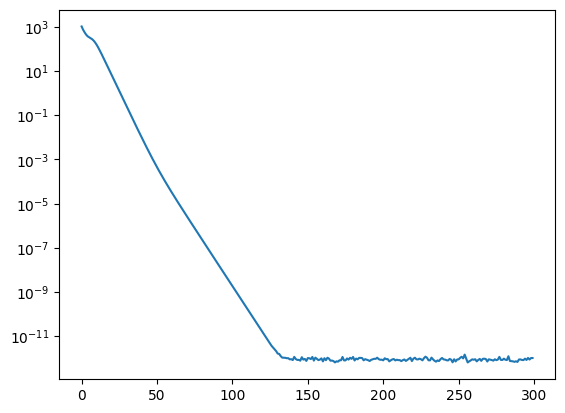

In [2]:
from matplotlib import pyplot as plt

plt.plot(errors)
plt.yscale('log')
